<a href="https://colab.research.google.com/github/rusherman/Learn-Vim_zh_cn/blob/master/pixar_of_KandinskyPipeline_ddim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# install

# 新段落

In [ ]:
! pip install git+https://github.com/huggingface/transformers
! pip install git+https://github.com/huggingface/diffusers.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-22igr1x8
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-22igr1x8
  Resolved https://github.com/huggingface/transformers to commit feb83521eca849731573dd40da89a02e4f370e5a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.7 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.31.0.dev0-py3-none-any.whl size=7202872 sha256=65acd972189bf06c92c3830898528dc4c53ea630202056edfa918e70da2081f0
  Stored in directory: /tmp/pip-ephem-w

In [ ]:
#! pip install wandb --upgrade wandb

# setup wandb

use wandb if you want to generate many images so that we can cherry pick

In [ ]:
%%capture
!pip install wandb
import wandb

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
run = wandb.init(project="pixal-ddim")

wandb: Currently logged in as: yiyixu. Use `wandb login --relogin` to force relogin


# img2img

### upload an image

In [ ]:
!ls

adina.jpg  sample_data


In [1]:
from PIL import Image
original_image = Image.open('adina.jpg')
original_image = original_image.resize((768, 768))

FileNotFoundError: ignored

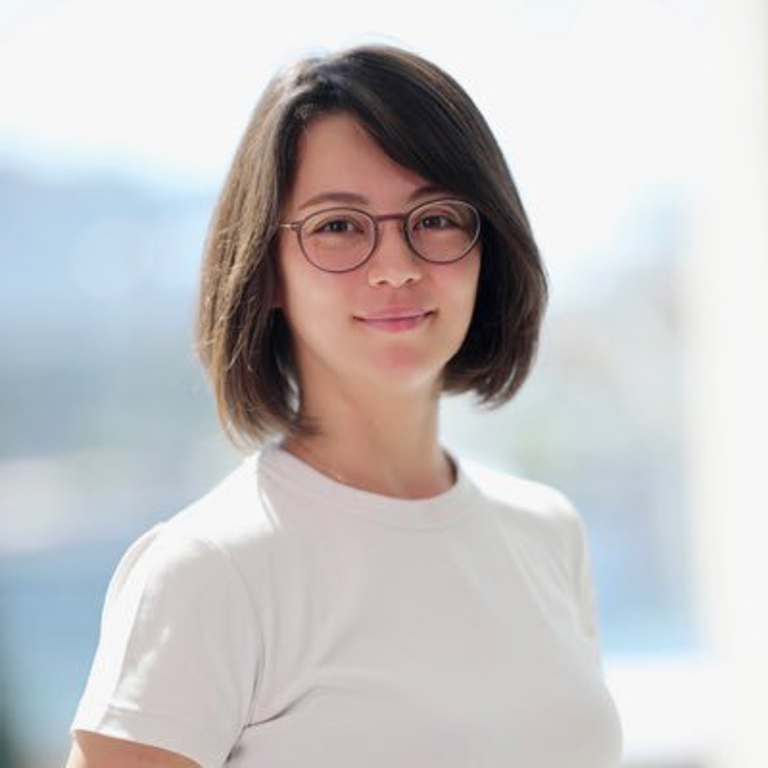

In [ ]:
original_image

## create pipelines

In [ ]:
import torch
from PIL import Image

In [ ]:
from diffusers import KandinskyImg2ImgPipeline, KandinskyPriorPipeline


# # create prior
pipe_prior = KandinskyPriorPipeline.from_pretrained("kandinsky-community/kandinsky-2-1-prior")
pipe_prior.to("cuda")


pipe = KandinskyImg2ImgPipeline.from_pretrained("kandinsky-community/kandinsky-2-1", torch_dtype=torch.float16)
pipe.to("cuda")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
You are using a model of type xlm-roberta to instantiate a model of type M-CLIP. This is not supported for all configurations of models and can yield errors.


KandinskyImg2ImgPipeline {
  "_class_name": "KandinskyImg2ImgPipeline",
  "_diffusers_version": "0.18.0.dev0",
  "movq": [
    "diffusers",
    "VQModel"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "kandinsky",
    "MultilingualCLIP"
  ],
  "tokenizer": [
    "transformers",
    "XLMRobertaTokenizerFast"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ]
}

## generate

In [ ]:
def generate_img2img(prompt, negative_prompt, seed, log_wandb=False, name=""):

    generator = torch.Generator(device='cuda').manual_seed(seed)
    image_emb, zero_image_emb = pipe_prior(
        prompt,
        guidance_scale = 4.,
        num_inference_steps=25,
        generator=generator,
        negative_prompt = negative_prompt).to_tuple()

    images = pipe(
        prompt,
        image=original_image,
        image_embeds=image_emb,
        negative_image_embeds =zero_image_emb,
        height=768,
        width=768,
        num_inference_steps=500,
        strength=0.15,
    ).images

    if log_wandb:
        wandb.log({f"{name}:{prompt[:10]}": [wandb.Image(image) for image in images]})
    return images

### pick a seed

In [ ]:
prompt = "Rtrait photography from Disney Pixar Studios, anime, babyface, a beautiful and lovely girl in her youth, wearing glasses, black eyes, high detail, art station seraflur sacred movie"
negative_prompt = 'low quality, bad quality'
seed = 10

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

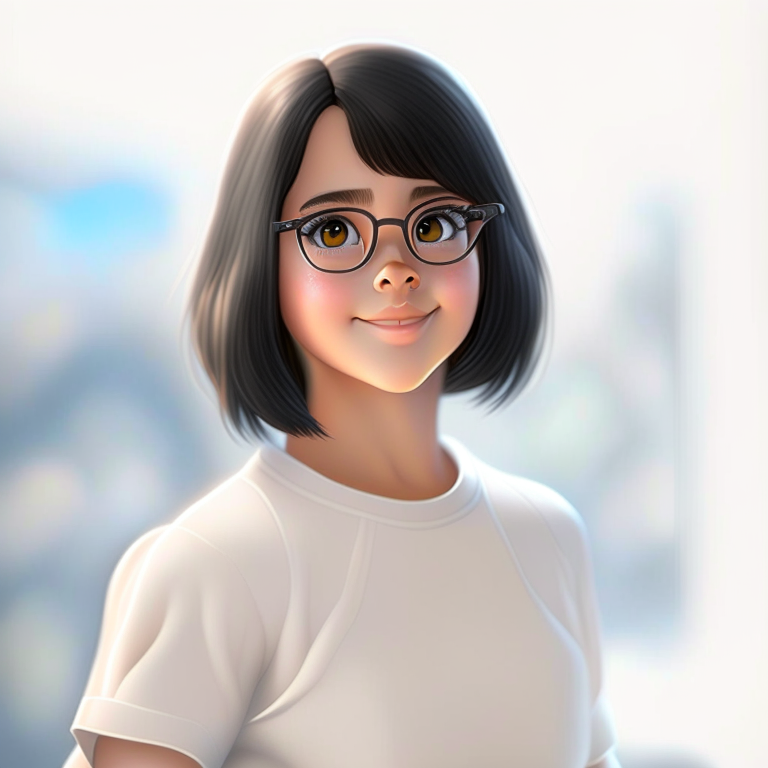

In [ ]:
images = generate_img2img(prompt, negative_prompt, seed)
images[0]

### use wandb (generate a lot to cherry pick)

In [ ]:
prompt = "Rtrait photography from Disney Pixar Studios, anime, babyface, a beautiful and lovely girl in her youth, wearing glasses, black eyes, high detail, art station seraflur sacred movie"
negative_prompt = 'low quality, bad quality'

for seed in range(0,100):
  _ = generate_img2img(prompt, negative_prompt, seed, log_wandb=True, name='adina_pixar')